# Report on Reducing hospital readmissions

## The following report is divided into 4 stages:
* Background - Gives context to this report
* Data Validation and Cleaning - Veryfing the integrity and tidiness of the data
* Targeted Analysis - Answering the specific questions through statistic analysis
* Predictions and Limitations - Ansewring the last question through machine learning algorithms, with data limitations

## 🏥 Background
You work for a consulting company helping a hospital group better understand patient readmissions. The hospital gave you access to ten years of information on patients readmitted to the hospital after being discharged. The doctors want you to assess if initial diagnoses, number of procedures, or other variables could help them better understand the probability of readmission. 

They want to focus follow-up calls and attention on those patients with a higher probability of readmission.

## 💾 Data info

#### Information in the file
- "age" - age bracket of the patient
- "time_in_hospital" - days (from 1 to 14)
- "n_procedures" - number of procedures performed during the hospital stay
- "n_lab_procedures" - number of laboratory procedures performed during the hospital stay
- "n_medications" - number of medications administered during the hospital stay
- "n_outpatient" - number of outpatient visits in the year before a hospital stay
- "n_inpatient" - number of inpatient visits in the year before the hospital stay
- "n_emergency" - number of visits to the emergency room in the year before the hospital stay
- "medical_specialty" - the specialty of the admitting physician
- "diag_1" - primary diagnosis (Circulatory, Respiratory, Digestive, etc.)
- "diag_2" - secondary diagnosis
- "diag_3" - additional secondary diagnosis
- "glucose_test" - whether the glucose serum came out as high (> 200), normal, or not performed
- "A1Ctest" - whether the A1C level of the patient came out as high (> 7%), normal, or not performed
- "change" - whether there was a change in the diabetes medication ('yes' or 'no')
- "diabetes_med" - whether a diabetes medication was prescribed ('yes' or 'no')
- "readmitted" - if the patient was readmitted at the hospital ('yes' or 'no') 

__My additional notes__:
1. <ins>Inpatient</ins> means the patient needed to be under watch 24/7 due to a major procedure, hence it needs to stay in the Hospital
2. <ins>Outpatient</ins> means the patient can be followed up in a secondary installation (like an health-center), hence it does not need 24/7 monitoring neither the permanence in the Hospital
3. <ins>A1C test</ins> or Hemoglobin A1C test acts as failsafe, showing the average of your glucose levels over the past 3 months. It is used to determine if a person is in fact diabetic (or pre-diabetic)

## ✅ Data Validation and Cleaning

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/hospital_readmissions.csv')
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


Although the data does not seem to have missing values, instead of the classical "NaN", missing data are in the form of "Missing" string.

The data integrity was validated as per follows:

- "age" - as per description, no missing values
- "time_in_hospital" - as per description, no missing values
- "n_procedures" - as per description, no missing values
- "n_lab_procedures" - as per description, no missing values
- "n_medications" - as per description, no missing values
- "n_outpatient" - as per description, no missing values
- "n_inpatient" - as per description, no missing values
- "n_emergency" - as per description, no missing values

__________
- "medical_specialty" - as per description, virtually __half__ of the whole observations fit in the category __"Missing"__. In a normal situation, I would scrutiny this issue and try to understand with the Hospital's doctors what is happening for such an amount of missing data. Not having that in hand, I will introduce some bias based on research: In Medicine academia, doctors whom only finished 3 to 4 years of studies (depending on the country) __do not possess a specialization__, which are the remaining years for a PhD. degree to be awarded. Hence, they __remain as General Practitioners__. Since there is a category "Family/GeneralPractice", and it is usually the __starting point of patients with symptoms__, I will impute said category in the missing values. Lastly, checking the boxplots below, we can see the most resemblence of the distribution of each categories, making me believe (with some bias) that "Family/GeneralPractice" would perhaps be the best fit.
__________

- "diag_1" - as per description, 4 missing values. Since those patients have secondary and additional diagnosis, I moved those values one column to the left.
- "diag_2" - as per description, 42 missing values. From those, 21 are missing when diag_3 is not missing. That does not make sense for a doctor to state a primary diagnosis, "Missing" on the secondary, and have an additional diagnosis. For the sake of logic, those 21 data points had their values switched, from diag_3 to diag_2, and diag_3 is now missing.
- "diag_3" - as per description, 196 missing values, but makes sense since patients had primary or secondary diagnosis.
- "glucose_test" - as per description, no missing values
- "A1Ctest" - as per description, no missing values
- "change" - as per description, no missing values
- "diabetes_med" - as per description, no missing values
- "readmitted" - as per description, no missing values 

In [3]:
#Checking for missing values and variable types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

In [4]:
#Analyzing distribution of numeric variables
df.describe()

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency
count,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,4.45332,43.24076,1.352360,16.252400,0.366400,0.615960,0.186600
std,3.00147,19.81862,1.715179,8.060532,1.195478,1.177951,0.885873
min,1.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.00000,31.00000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,4.00000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000
75%,6.00000,57.00000,2.000000,20.000000,0.000000,1.000000,0.000000
max,14.00000,113.00000,6.000000,79.000000,33.000000,15.000000,64.000000


In [5]:
#Overwriting  missing diag_1 with valid values of diag_2, and values from diag_2 with diag_3
filter_diag1 = df.diag_1 == "Missing"
df["diag_1"][filter_diag1] = df["diag_2"][filter_diag1]
df["diag_2"][filter_diag1] = df["diag_3"][filter_diag1]
df["diag_3"][filter_diag1] = "Missing"

In [6]:
#Overwriting missing diag_2 with valid values of diag_3
filter_diag2 = (df.diag_2 == "Missing") & (df.diag_3 != "Missing") 
df["diag_2"][filter_diag2] = df["diag_3"][filter_diag2] 
df["diag_3"][filter_diag2] = "Missing"

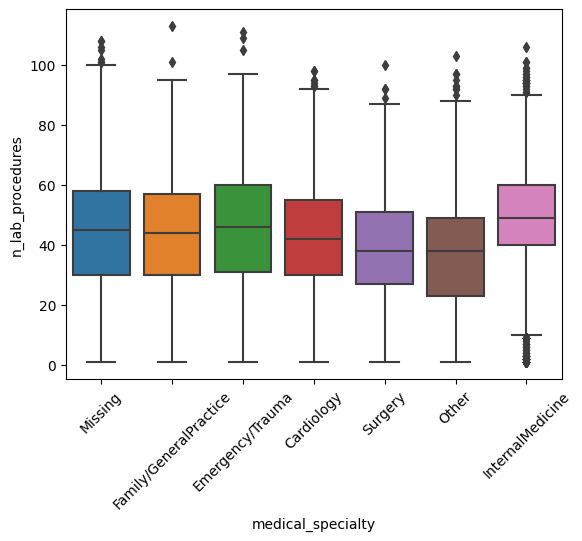

Missing                   0.49528
InternalMedicine          0.14260
Other                     0.10656
Emergency/Trauma          0.07540
Family/GeneralPractice    0.07528
Cardiology                0.05636
Surgery                   0.04852
Name: medical_specialty, dtype: float64


In [7]:
#Comparing categories of medical_specialty with n_lab_procedures
order = ["Missing", "Family/GeneralPractice", "Emergency/Trauma", "Cardiology", "Surgery", "Other", "InternalMedicine"]
sns.boxplot(x = "medical_specialty", y = "n_lab_procedures", data = df, order = order)
plt.xticks(rotation = 45)
plt.show()

#Showing proportions of each category
print(df.medical_specialty.value_counts(normalize = True))

In [8]:
df["medical_specialty"] = df["medical_specialty"].replace({"Missing": "Family/GeneralPractice"})

## 🎯 Targeted Analysis

Answering the first two questions of analysis: 

1. __Q: "What is the most common primary diagnosis by age group?"__
__A:__ For the age group between 40 (inclusive) and 50 (exclusive), the most common primary diagnosis is "Other", while in the other remaining age groups, the most common is "Circulatory"

2. __Q: "Some doctors believe diabetes might play a central role in readmission. Explore the effect of a diabetes diagnosis on readmission rates."__
__A:__ The patients were divided into two classes on the "has_diabetes" variable: 0 - "Does not have Diabetes" and 1 - "Has Diabetes". Then, they were also divided within the binary class of "readmitted". 
Comparing both batches, the "Does not have Diabetes" has identical proportions than the "Has Diabetes", meaning that something else may be responsible for the readmissions.

Backing up this data, let's formulate two hypothesis:
* __H0: Diabetes does not play a role in the readmisson rate, there is no correlation__
* __Ha: Diabetes plays a role in readmission rate, there is a correlation__

Executing a Logistic Regression model between independent variables ("diag_1", "diag_2", and "diag_3") and dependent variables ("readmitted"), __we can see that the primary, secondary and additional diagnosis of Diabetes are correlated with the dependent variable, with p-value lower than a significance level of 0.05, therefore, we have enough evidence to reject the Null Hypothesis H0__. However, with a Pseudo R-value of aproximately 0, these variables explain very little of the dependent variable variance.

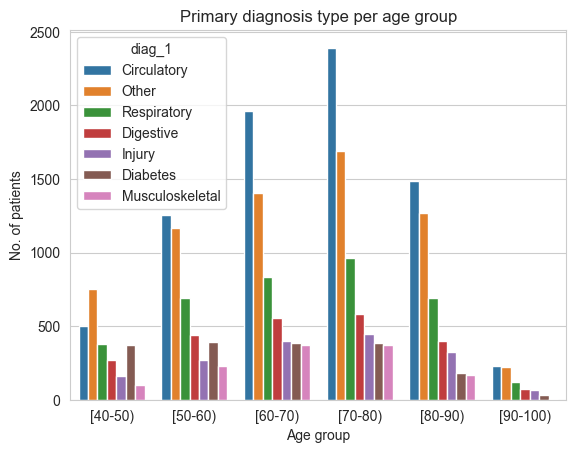

age
[40-50)           Other
[50-60)     Circulatory
[60-70)     Circulatory
[70-80)     Circulatory
[80-90)     Circulatory
[90-100)    Circulatory
Name: diag_1, dtype: object


In [9]:
#Plot most primary diagnosis type per age group
hue_order = ["Circulatory", "Other", "Respiratory", "Digestive", "Injury", "Diabetes", "Musculoskeletal"]
order = ["[40-50)", "[50-60)", "[60-70)", "[70-80)", "[80-90)", "[90-100)"]
sns.set_style("whitegrid")
sns.countplot(x = "age", hue = "diag_1", data = df, order = order, hue_order = hue_order)
plt.title("Primary diagnosis type per age group")
plt.xlabel("Age group")
plt.ylabel("No. of patients")
plt.show()

#Print results 
print(df.groupby("age")["diag_1"].agg(pd.Series.mode))

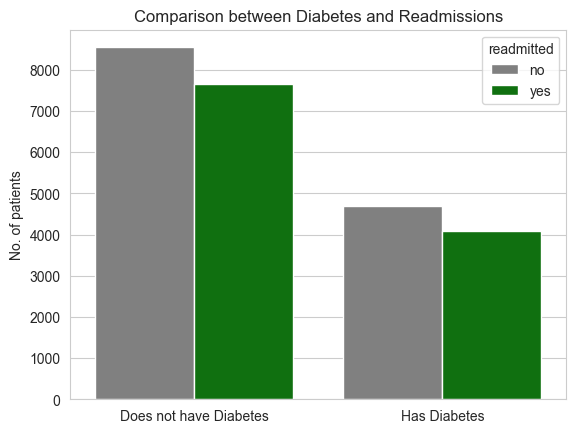

In [10]:
#Create column with 1 if the patient has diabetes, and 0 if it does not
df["has_diabetes"] = np.where(df.diag_1 == "Diabetes", 1, \
                              np.where(df.diag_2 == "Diabetes", 1, \
                                       np.where(df.diag_3 == "Diabetes", 1, 0)))

#Plot findings
sns.countplot(x = "has_diabetes", hue = "readmitted",  data = df, palette = {"no" : "gray", "yes" : "green"})
plt.title("Comparison between Diabetes and Readmissions")
plt.xticks([0, 1], labels = ["Does not have Diabetes", "Has Diabetes"])
plt.ylabel("No. of patients")
plt.xlabel("")
plt.show()

In [11]:
#Running a Logistic Regression model to see if the "readmitted" variable is explained by "has_diabetes"
import statsmodels.formula.api as smf
df["readmitted"] = df["readmitted"].replace({"no": 0, "yes": 1})
results = smf.logit("readmitted ~ C(diag_1) + C(diag_2) + C(diag_3) + 0", data = df).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.688612
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24979
Method:                           MLE   Df Model:                           20
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                0.003983
Time:                        22:58:27   Log-Likelihood:                -17215.
converged:                       True   LL-Null:                       -17284.
Covariance Type:            nonrobust   LLR p-value:                 1.394e-19
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
C(diag_1)[Circulatory]          -0.0223      0.031     -0.714      0.475

## 🔮 Predictions and Limitations

Answering the last queston of analysis:

3. __Q: "On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?"__
__A:__ Taking in consideration that the data itself can only explain the readmittion rate to such degree, the 3 variables that influence the model the most are "n_inpatient", "n_emergency" and "has_diabetes", by that order.
Key notes:
* The higher the number of inpatient visits (under 24/7 watch in the Hospital) the previous year,
* The higher the number of emergency visits the previous year, and
* The fact that a person does not have Diabetes, the higher the probability of the patient being readmitted.

__Since any of the used models predict the target variable well, with this data, I would tell the Hospital to focus on patients that have spent the most time in care units and had more emergency visits the previous year.__

The fact that a person is diagnosed with Diabetes can be misleading, since being __primarly, secondary or additionaly diagnosed with Diabetes__ contributes positively for the probability of being readmitted, and at the same time, __having diabetes__ contributes negatively for the probability of being readmitted.

Maybe there are several cases where people with and without Diabetes are readmitted and more data is needed to have higher levels of prediction. I recommend looking for the reason why each readmission happens. Usually Doctors write a small text with the reason/ complaints of each patient. Accessing this information and classifying it by topics via Non-Negative Matrix Factorization algorithm, thus creating a new categorical variable, would be something I would discuss with the Team as a next step

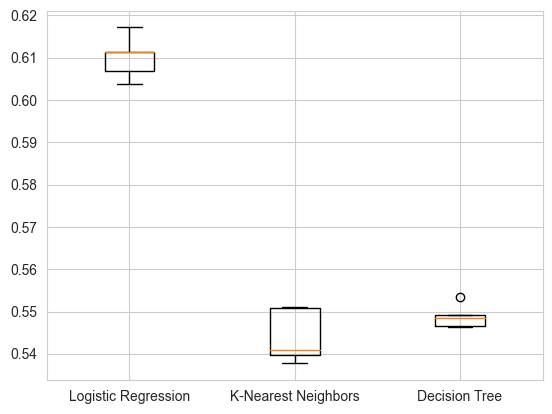

In [12]:
#Importing necessary packages
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#Defining explanatory variables, target variable and split data
X_dummies = pd.get_dummies(df)
y = df["readmitted"].values
X = X_dummies.drop("readmitted", axis = 1).values
SEED = 9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

#Pre-processing data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#Models to run
models = {"Logistic Regression": LogisticRegression(),
          "K-Nearest Neighbors": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier()}

#K-fold cross validation in all models
results = []
for model in models.values():
    kf = KFold(shuffle = True, random_state = SEED)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv = kf)
    results.append(cv_results)

#Plot models' performance
plt.boxplot(results, labels = models.keys())
plt.show()

In [13]:
#Running a Logistic Regression base model
logreg = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.59      0.80      0.68      3934
           1       0.64      0.40      0.49      3566

    accuracy                           0.61      7500
   macro avg       0.62      0.60      0.59      7500
weighted avg       0.62      0.61      0.59      7500



In [14]:
# If the variables are not scaled, use the line of code below to multiply the standard deviation to the coefficients
#coefficients_times_std = np.std(X, 0)* coefficients

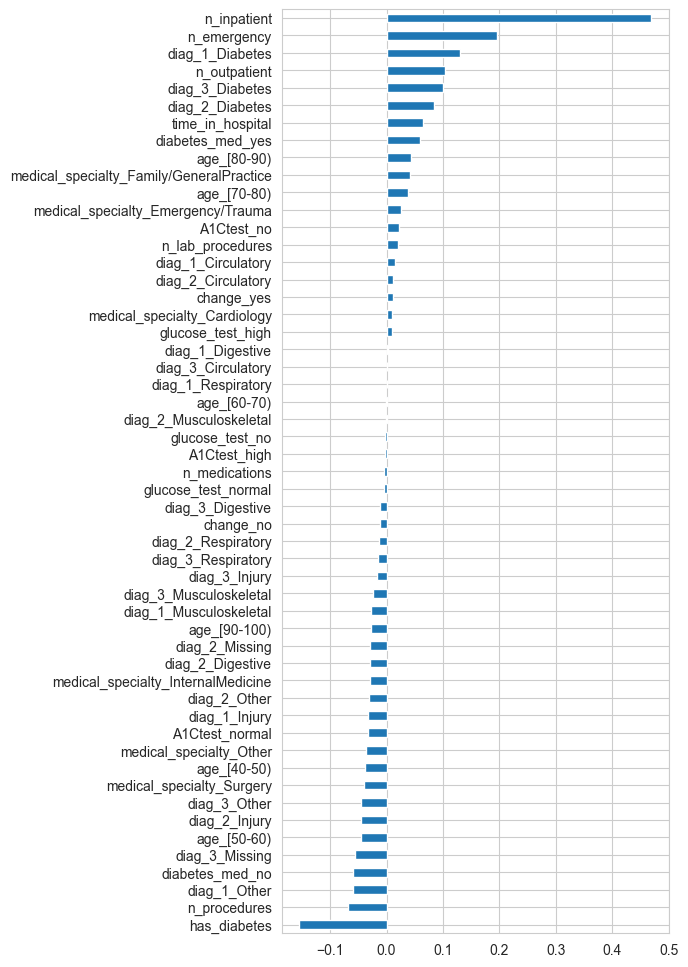

In [15]:
#Ploting feature importance
coefficients = logreg.coef_[0]
feature_importance = pd.Series(coefficients, index = X_dummies.drop("readmitted", axis = 1).columns).sort_values()
feature_importance.plot(kind = "barh", figsize = (5, 12))
plt.show()